## Introdução e o Dataset   
   O dataset utilizado neste exercício foi o dataset Previsão de Segurança do Motorista, disponibilizado pela Porto Seguro. Há um desbalanceamento na classe de saída e vamos descobrir como lidar com esse tipo de dado.
    Em um primeiro momento, devemos fazer a análise exploratória dos dados.
    
#### About this Dataset

#### Data Description

In this competition, you will predict the probability that an auto insurance policy holder files a claim.

In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.

#### File descriptions
- train.csv contains the training data, where each row corresponds to a policy holder, and the target columns signifies that a claim was filed.
- test.csv contains the test data.
- sample_submission.csv is submission file showing the correct format.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

In [2]:
train=pd.read_csv('../data/porto-seguro/train.csv', na_values=-1)
test=pd.read_csv('../data/porto-seguro/test.csv', na_values=-1)

In [3]:
train.isnull().values.any()

True

In [4]:
features = train.drop(['id','target'], axis=1).values
targets = train.target.values

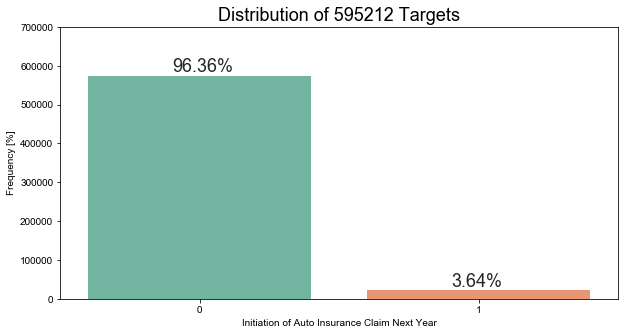

In [5]:
ax = sns.countplot(x = targets ,palette="Set2")
sns.set(font_scale=1.5)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=700000)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(targets)), (p.get_x()+ 0.3, p.get_height()+10000))

plt.title('Distribution of 595212 Targets')
plt.xlabel('Initiation of Auto Insurance Claim Next Year')
plt.ylabel('Frequency [%]')
plt.show()

## O que podemos fazer?

- As classes de previsão estão muito desbalanceadas
- Alto viés para o 0 (se chutar tudo 0 pode acertar abstante)
- Devemos ter alguma ponderação para balancear as classes na hora de treinar

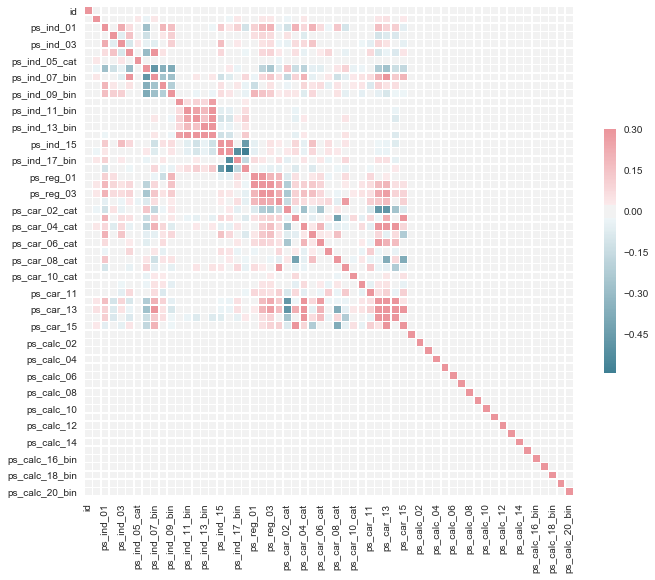

In [6]:
sns.set(style="white")


# Compute the correlation matrix
corr = train.corr()


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Podemos ver que:
- ps_calc_* não estão relacionadas com a classe desejada
- Podemos removê-las para evitar curse of dimensionality

In [7]:
# Define the gini metric - from https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703#5897
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

In [8]:
unwanted = train.columns[train.columns.str.startswith('ps_calc_')]
train = train.drop(unwanted, axis=1)  
test = test.drop(unwanted, axis=1)  

Como lidar com classes desbalanceadas?

Stratified Kfold !

Stratified KFold é utilizada para manter a distribuição de cada label consistente entre cada batch de treinamento.


In [9]:
kfold = 5
skf = StratifiedKFold(n_splits=kfold, random_state=42)

In [10]:
# More parameters has to be tuned. Good luck :)
params = {
    'min_child_weight': 10.0,
    'objective': 'binary:logistic',
    'max_depth': 7,
    'max_delta_step': 1.8,
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'eta': 0.025,
    'gamma': 0.65,
    'num_boost_round' : 700
    }

Treinamento

In [11]:
X = train.drop(['id', 'target'], axis=1).values
y = train.target.values
test_id = test.id.values
test = test.drop('id', axis=1)

In [12]:
sub = pd.DataFrame()
sub['id'] = test_id
sub['target'] = np.zeros_like(test_id)

In [13]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    # Convert our data into XGBoost format
    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    d_test = xgb.DMatrix(test.values)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    # Train the model! We pass in a max of 1,600 rounds (with early stopping after 70)
    # and the custom metric (maximize=True tells xgb that higher metric is better)
    mdl = xgb.train(params, d_train, 1600, watchlist, early_stopping_rounds=70, feval=gini_xgb, maximize=True, verbose_eval=100)

    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    # Predict on our test data
    p_test = mdl.predict(d_test, ntree_limit=mdl.best_ntree_limit)
    sub['target'] += p_test/kfold

[Fold 1/5]
[0]	train-error:0.036447	valid-error:0.036449	train-gini:0.031021	valid-gini:0.036149
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
[100]	train-error:0.036447	valid-error:0.036449	train-gini:0.323494	valid-gini:0.265507
[200]	train-error:0.036445	valid-error:0.036449	train-gini:0.361947	valid-gini:0.273154
[300]	train-error:0.036428	valid-error:0.036449	train-gini:0.397185	valid-gini:0.27744
[400]	train-error:0.03642	valid-error:0.036441	train-gini:0.426033	valid-gini:0.279409
Stopping. Best iteration:
[409]	train-error:0.036422	valid-error:0.036441	train-gini:0.428422	valid-gini:0.27961

[Fold 1/5 Prediciton:]
[Fold 2/5]
[0]	train-error:0.036447	valid-error:0.036449	train-gini:0.031254	valid-gini:0.042578
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
[100]	train-error:0.036447	va